#Exploratory Data Analysis & Feature Engineering
在探索性数据分析（EDA）阶段，我们首先研究了歌曲流行度的分布，以了解冷启动场景。结果显示，流行度分布高度右偏：大多数歌曲流行度较低，只有少数歌曲非常流行。这证实了预测流行度具有挑战性，并且目标变量存在不平衡问题。随后，我们使用相关性分析研究了音频特征与流行度之间的关系。我们发现，流行度并非由单个特征线性决定，而是受到多种因素的影响。我们还分析了不同音乐类型的平均流行度，发现某些类型的歌曲比其他类型的歌曲更受欢迎，这可以作为新发布歌曲的有用先验信息。此外，音频特征之间的相关性表明，某些特征（例如能量和响度）之间存在很强的关联。最后，通过将响度划分为不同的区间，我们观察到响度较高的歌曲平均流行度也较高，这表明响度与流行度之间存在非线性关系。

3.1 Clean EDA: Understanding Popularity Drivers (Cold-Start Context)

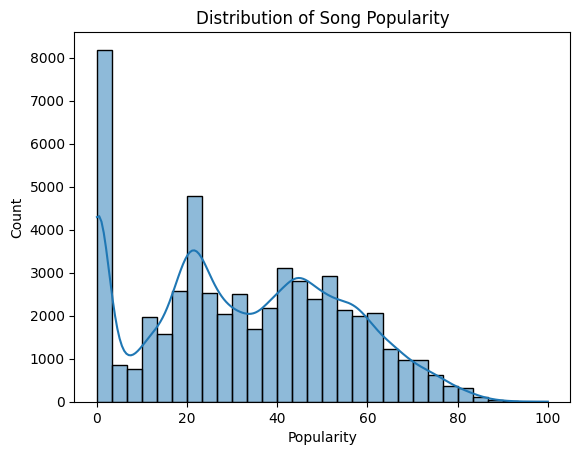

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Distribution of Song Popularity")
plt.xlabel("Popularity")
plt.show()


Popularity is highly right-skewed, with most songs having low popularity and a small number of hits.

##EDA 2: Correlation Between Audio Features and Popularity

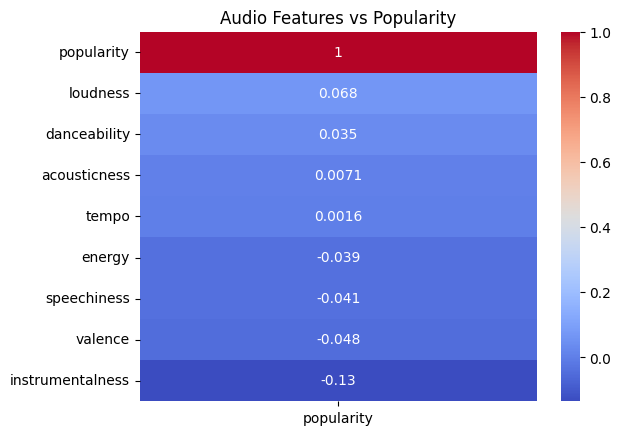

In [ ]:
audio_features = [
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo'
]

corr = df[['popularity'] + audio_features].corr()

sns.heatmap(
    corr[['popularity']].sort_values(by='popularity', ascending=False),
    annot=True,
    cmap='coolwarm'
)
plt.title("Audio Features vs Popularity")
plt.show()


The correlation results show that no single audio feature strongly explains song popularity. This suggests that popularity is influenced by multiple factors, and simple linear relationships are not sufficient.

##EDA 3: Genre-level Popularity Prior

In [ ]:
genre_popularity = (
    df.groupby('track_genre')['popularity']
      .mean()
      .sort_values(ascending=False)
)

genre_popularity.head(10)


,popularity
track_genre,
chill,53.651
grunge,49.594
anime,48.772
emo,48.128
deep-house,44.808
brazil,44.670
electronic,44.325
ambient,44.191
british,43.802


This analysis shows the average popularity for each genre.
Genre information can serve as a useful prior in cold-start recommendation.

##EDA 4: Audio Features vs Popularity
Which audio features are most related to song popularity?

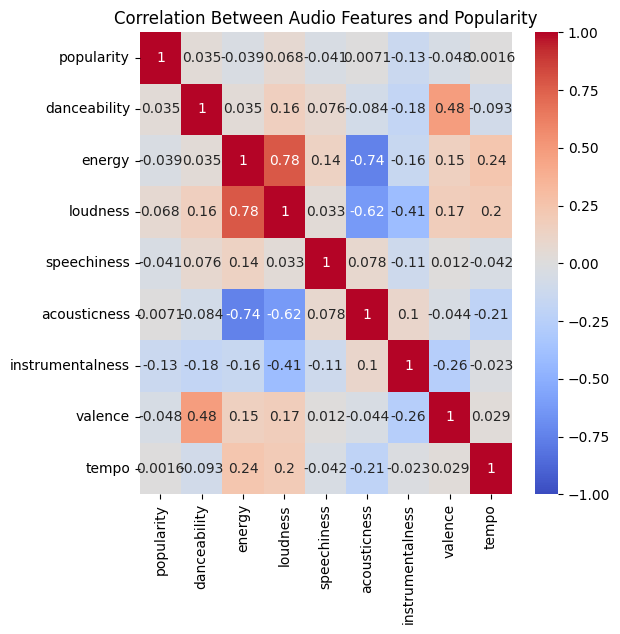

In [ ]:
audio_features = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'valence',
    'tempo'
]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
sns.heatmap(
    df[['popularity'] + audio_features].corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title("Correlation Between Audio Features and Popularity")
plt.show()



This heatmap shows that most audio features have weak correlations with popularity, while some features are strongly correlated with each other.

##EDA 5: Binning Continuous Features (Loudness / Tempo)

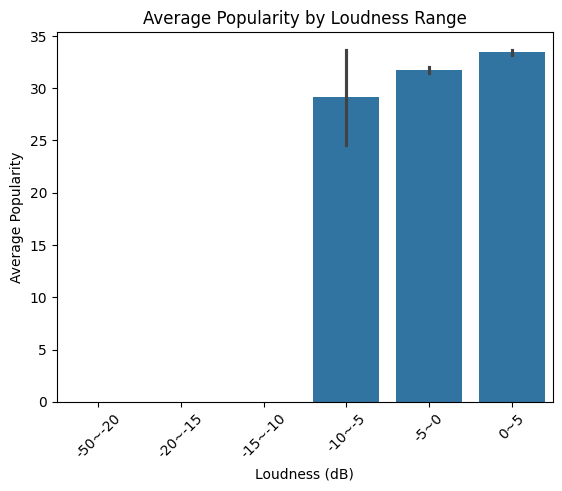

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loudness binning
bins = [-50, -20, -15, -10, -5, 0, 5]
labels = ['-50~-20', '-20~-15', '-15~-10', '-10~-5', '-5~0', '0~5']

df['loudness_bin'] = pd.cut(df['loudness'], bins=bins, labels=labels)

sns.barplot(
    data=df,
    x='loudness_bin',
    y='popularity',
    estimator='mean'
)
plt.title("Average Popularity by Loudness Range")
plt.xlabel("Loudness (dB)")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.show()


Louder songs tend to have higher popularity on average.

#Feature Engineering
基于探索性数据分析（EDA）结果和冷启动限制，我们设计了在发布时即可获得的特征。所有音频特征都进行了标准化处理，以确保它们在模型训练过程中具有可比的尺度。为了处理倾斜的流行度分布，我们使用基于分位数的分箱方法将流行度转换为三个级别（低、中、高），从而为分类任务创建了更平衡的目标变量。我们将流派级别的平均流行度作为先验特征添加，为新歌曲提供额外信息。我们还通过对器乐性特征设置阈值，创建了一个二元指标来指示歌曲是否主要为器乐曲。为了建模非线性效应，我们将响度离散化为类别区间，而不是使用原始值。最后，我们对舞曲性、能量和情感值应用了 KMeans 聚类算法，生成了情绪簇。这些簇代表不同的歌曲情绪，并且完全基于音频特征生成，因此在没有用户交互数据的情况下，它们对于冷启动流行度预测和推荐尤其有用。

Create useful features that are available at release time to predict popularity and support recommendation

#Scale Audio Features

In [ ]:
from sklearn.preprocessing import StandardScaler

audio_features = [
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo'
]

scaler = StandardScaler()
df[audio_features] = scaler.fit_transform(df[audio_features])


Audio features are scaled using standardization so that each feature has equal importance during model training.

#Popularity Level
Popularity is converted into three levels to handle the skewed distribution.

In [ ]:
df['popularity_level'] = pd.qcut(
    df['popularity'],
    q=3,
    labels=['low', 'medium', 'high']
)

df['popularity_level'].value_counts()


,count
popularity_level,
medium,18357
low,18354
high,17075


Popularity is converted into three levels (low, medium, high) using quantile-based binning.
This helps handle the skewed distribution and creates a balanced classification target.

##Genre Popularity Prior
Genre-level average popularity is used as a prior for new songs.

In [ ]:
genre_prior = df.groupby('track_genre')['popularity'].mean()
df['genre_popularity_prior'] = df['track_genre'].map(genre_prior)


##Instrumental Indicator
Instrumental songs are marked with a binary indicator.

In [ ]:
df['is_instrumental'] = (df['instrumentalness'] > 0.8).astype(int)


An instrumental indicator is created by thresholding the instrumentalness feature.
Songs with instrumentalness greater than 0.8 are labeled as instrumental.
This binary feature captures whether a song is primarily instrumental.

##Loudness Bin
Loudness is binned to capture non-linear effects.

In [ ]:
df['loudness_bin'] = pd.cut(
    df['loudness'],
    bins=[-50, -20, -15, -10, -5, 0, 5],
    labels=['very quiet','quiet','medium','loud','very loud','extreme']
)


很安静的歌不太火

中等到偏响的歌更容易火

Loudness is binned into discrete ranges to capture non-linear effects.
This feature represents whether a song is quiet or loud rather than its exact loudness value.

##Mood Clustering

In [ ]:
from sklearn.cluster import KMeans

cols = ['danceability', 'energy', 'valence']

X = df[cols].copy()
X = X.fillna(X.median())   # 填补缺失值

kmeans = KMeans(n_clusters=4, random_state=42)
df['mood_cluster'] = kmeans.fit_predict(X)

df['mood_cluster'].value_counts()


,count
mood_cluster,
2,16675
1,15590
0,12877
3,8645


The songs are categorized into four emotional categories based on their danceability, energy, and emotional tendency.
Each category represents a different song mood.
These categories provide a potential representation that can be used for cold-start recommendations.

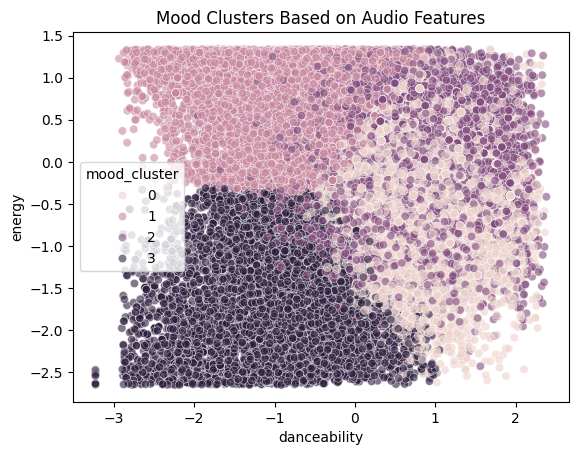

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df,
    x='danceability',
    y='energy',
    hue='mood_cluster',
    alpha=0.6
)
plt.title("Mood Clusters Based on Audio Features")
plt.show()


Since mood clusters are derived purely from audio features, they can be used to represent song characteristics even for newly released tracks without user interaction data.